In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Generate data

In [2]:
np.random.seed(42)

samples = 50_000

In [3]:
# generate features
oned_X = np.random.uniform(0, 100, samples) + np.sin(samples) # some additional noise
X = oned_X.reshape(500, -1) # transform oned_X into matrix

# generate targtes
raw_target = np.mean(X, axis=1)
y = (raw_target > 50).astype(int)

# Train-Test Split (80/20)

In [4]:
def train_test_split(X, y):
    chunk = X.shape[0]
    X_train, X_test = X[:round(chunk*0.8), :], X[round(chunk*0.8):, :]
    y_train, y_test = y[:round(chunk*0.8)], y[round(chunk*0.8):]

    return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Scale The Data

In [6]:
class StandartScaler():
    def __init__(self, X_train, X_test):
        self.X_train = X_train
        self.X_test = X_test

    def fit(self, X_train):

        '''The Scaler firt training data'''

        self.mean = np.mean(self.X_train)
        self.std = np.std(self.X_train)

    def transform(self, data, train=None):

        '''The Scaler transform data'''
        
        if train:
            self.data = (self.X_train - self.mean) / self.std
            return self.data
        else:
            self.data = (self.X_test - self.mean) / self.std
            return self.data

In [7]:
# create new instance
scaler = StandartScaler(X_train, X_test)

# fit scaler only on training data
scaler.fit(X_train)

# perform scaling on train data
X_train_scaled = scaler.transform(X_train, train=True)
print(f'Original Training Data: {X_train[0, 0]}')
print(f'Scaled Training Data: {X_train_scaled[0, 0]}')

# and on test
X_test_scaled = scaler.transform(X_test, train=False)

Original Training Data: 36.45417169564646
Scaled Training Data: -0.4331365430062197


 # Define Training loop and all main functions

In [140]:
def sigmoid(z):
    '''Implement Signmoid Function'''
    return np.where(z >= 0, 1/(1 + np.exp(-z)), np.exp(z)/(1 + np.exp(z)))

def loss_func(y, p):
    '''Implement Loss Function'''
    return -(1/len(y)) * np.sum(y*np.log(p) + (1 - y)*np.log(1 - p))

def ridge_gradient(alpha, w):
    '''Gradient of L2-regularization'''
    return (alpha * w) / len(y)

def reduce_on_plateau(lr, factor=0.1, stop=1e-6):
    '''Reduce Learning Rate on Plateau'''
    if lr > stop:
        return lr * factor
    return lr

### Trainig Loop

In [141]:
round(2000 * 0.1)

200

In [ ]:
def train_logistic_regression(X, y, lr=0.1, epochs=2000, patience=None,
                              alpha=None, scheduler=None):
    
    '''Training Loop'''

    w = np.zeros(shape=(X.shape[1], 1), dtype=np.float64) # initialize weights
    b = 0.0 # initialize bias

    # lists for statistic and another staff accumulation
    running_accuracy_list = []
    loss_list = []
    train_weights = []
    train_bias = []
    learning_rate = []

    y = y.reshape(-1, 1)
    # main loop
    for epoch in tqdm(range(epochs), desc='Training Logistic Regression'):
        # get probabilities from model
        raw_probs = sigmoid(X @ w + b)

        # calculate loss
        loss = loss_func(y, raw_probs)
        loss_list.append(loss)

        # calculate partial derivative of loss function
        dw = (X.T @ (raw_probs - y)) / len(y)
        db = np.mean(raw_probs - y)

        # implement L2 regularization & gradient descent
        if alpha:
            w = w - lr * dw + ridge_gradient(alpha, w)
            b = b - lr * db
        else:
            w = w - lr * dw
            b = b - lr * db

        #final probabilities
        probs = sigmoid(X @ w + b)
        model_answer = (probs > 0.5).astype(int) # !!! (raw_probs)
        running_correct_pred = np.equal(model_answer, y)
        running_acc = np.sum(running_correct_pred) / len(y)
        running_accuracy_list.append(running_acc)

        # implement early stopping technique
        if epoch > epochs * 0.5 and patience:
            for i in range(len(running_accuracy_list)):
                if running_accuracy_list[i] <= running_accuracy_list[i-1]:
                    patience -= 1
                    if patience == 0:
                        print(f'Early Stopping!!!\nFinal Accuracy: {running_acc}\nFinal LearningRate: {lr:.4f}')
            break

        if epoch % 300 == 0:
            print(f'Current Train Accuracy: {running_acc}')
            # saving model weights
            train_weights.append(w)
            train_bias.append(b)

        #implemet Scheduler
        if scheduler and (epoch % 5 == 0):
            _patience = 0
            _patience_limit = round(epochs * 0.21)
            for i in range(len(running_accuracy_list)):
                if running_accuracy_list[i] <= running_accuracy_list[i-1]:
                    _patience += 1
                else:
                    _patience = 0
                if _patience >= _patience_limit:
                    lr = reduce_on_plateau(lr)
                    learning_rate.append(lr)
                    _patience = 0

    # calculate accuracy
    prob = sigmoid(X @ w + b)
    final_prob = (prob > 0.5).astype(int)
    acc = np.mean(final_prob == y)

    return running_accuracy_list, loss_list, acc, np.array(train_weights), np.array(train_bias), learning_rate

In [178]:
train_running_acc, train_loss, train_accuracy, weight, bias, lr = train_logistic_regression(X_train_scaled, y_train, 
                                                                                        patience=True, alpha=0.001,
                                                                                        scheduler=True)

Training Logistic Regression:  50%|█████     | 1001/2000 [00:00<00:00, 18725.24it/s]

Current Train Accuracy: 0.9125
Current Train Accuracy: 0.99
Current Train Accuracy: 1.0
Current Train Accuracy: 1.0
Early Stopping!!!
Final Accuracy: 1.0
Final LearningRate: 0.0001


Final Train Accuracy: 1.0
Final Train Loss: 0.0652


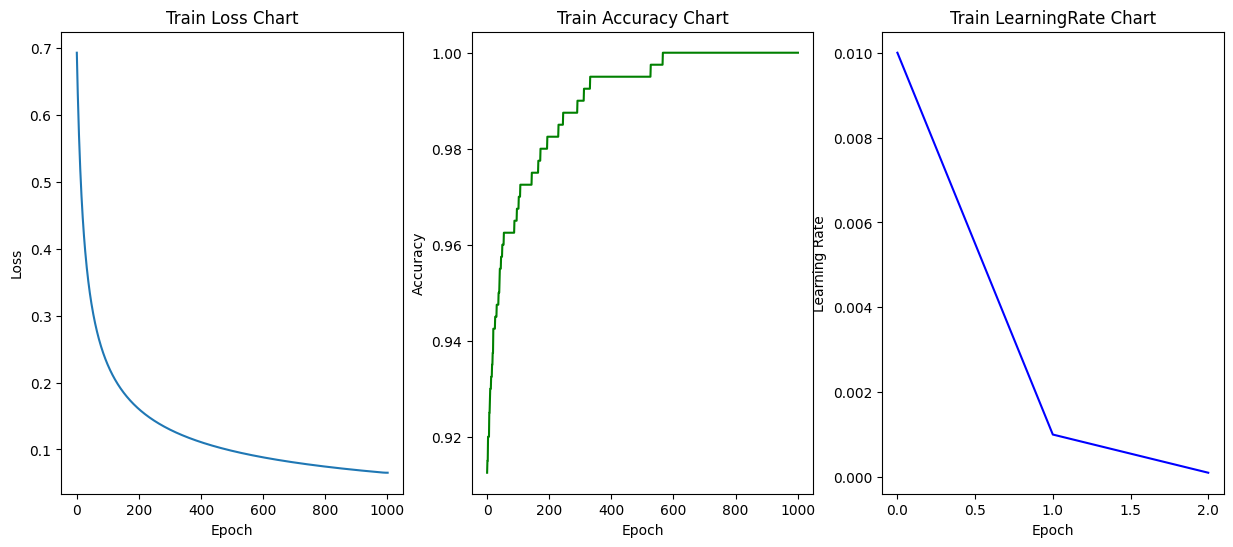

In [182]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

axs[0].plot(train_loss)
axs[0].set_title('Train Loss Chart')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].plot(train_running_acc, '-g')
axs[1].set_title('Train Accuracy Chart')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')

axs[2].plot(lr, '-b')
axs[2].set_title('Train LearningRate Chart')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Learning Rate')

print(f'Final Train Accuracy: {train_accuracy}')
print(f'Final Train Loss: {train_loss[::-1][0]:.4f}')

# Validate Model

In [180]:
def validate_logistic_regression(X, y):
    '''Validation Loop'''
    preds = sigmoid(X @ weight[::-1][0] + bias[::-1][0])

    # calculate test loss
    loss = loss_func(y.reshape(-1, 1), preds)

    # calculate test accuracy
    final_model_answer = [1 if i > 0.5 else 0 for i in preds]
    correct_pred = np.equal(final_model_answer, y)
    acc = np.sum(correct_pred) / len(preds)
    
    return acc, loss

### Final Test Metrics

In [181]:
test_acc, test_loss = validate_logistic_regression(X_test_scaled, y_test)

print(f'Test Accuracy: {test_acc}\nTest Loss: {test_loss:.3f}')

Test Accuracy: 0.92
Test Loss: 0.191
